# Evaluation of internal variables

## The problem

We want so solve the equation

$$\nabla^2 u = -f(x, y)\quad \forall (x, y) \in \Omega\, ,$$

with

$$u(x) = g(x, y), \quad \forall (x, y)\in \partial \Omega \, .$$


For this method, we need to use an integral representation of the equation,
that, in this case, is

$$u(\boldsymbol{\xi})  = \int_{S} [u(\mathbf{x}) F(\mathbf{x}, \boldsymbol{\xi})
        - q(\mathbf{x})G(\mathbf{x}, \boldsymbol{\xi})]\mathrm{d}S(\mathbf{x})
        + \int_{V} f(\mathbf{x}) G(\mathbf{x}, \boldsymbol{\xi}) \mathrm{d}V(\mathbf{x})$$


with

$$G(\mathbf{x}, \boldsymbol{\xi})= -\frac{1}{2\pi}\ln|\mathbf{x} - \xi|$$

and

$$F(\mathbf{x}, \boldsymbol{\xi}) =
      -\frac{1}{2\pi |\mathbf{x} - \boldsymbol{\xi}|^2}
      (\mathbf{x} - \boldsymbol{\xi})\cdot\hat{\mathbf{n}}$$

## Evaluation of the integral

We want to evaluate the integral

$$u(\boldsymbol{\xi})  = \int_{S} [u(\mathbf{x}) F(\mathbf{x}, \boldsymbol{\xi})
- q(\mathbf{x})G(\mathbf{x}, \boldsymbol{\xi})]\mathrm{d}S(\mathbf{x})
+ \int_{V} f(\mathbf{x}) G(\mathbf{x}, \boldsymbol{\xi})\mathrm{d}V(\mathbf{x})$$

if $f(\mathbf{x})$ is zero, it reads


$$u(\boldsymbol{\xi})  = \int_{S} [u(\mathbf{x}) F(\mathbf{x}, \boldsymbol{\xi})
- q(\mathbf{x})G(\mathbf{x}, \boldsymbol{\xi})]\mathrm{d}S(\mathbf{x})\, .$$

After discretizing the boundary it turns into

$$u(\boldsymbol{\xi})  = \sum_e \int_{S_e} [u(\mathbf{x}) F(\mathbf{x}, \boldsymbol{\xi}) - q(\mathbf{x})G(\mathbf{x}, \boldsymbol{\xi})]\mathrm{d}S(\mathbf{x})\, .$$

If we assume that the variable and flux is constant over each element we have


$$u(\boldsymbol{\xi})  = \sum_e  \left[u(\mathbf{x}_m) \int_{S_e}F(\mathbf{x}, \boldsymbol{\xi})\mathrm{d}S(\mathbf{x})
- q(\mathbf{x}_m) \int_{S_e}G(\mathbf{x}, \boldsymbol{\xi})\mathrm{d}S(\mathbf{x})\right]\, ,$$


where $\mathbf{x}_m$ is the position of the midpoint of each element. If we further assume that the Green functions are constant, we get

\begin{align*}
u(\boldsymbol{\xi}) &\approx \sum_e  \left[u(\mathbf{x}_m) F(\mathbf{x}_m, \boldsymbol{\xi})\int_{S_e}\mathrm{d}S(\mathbf{x})
- q(\mathbf{x}_m) G(\mathbf{x}_m, \boldsymbol{\xi})\int_{S_e}\mathrm{d}S(\mathbf{x})\right]\\
&= \sum_e  \left[u(\mathbf{x}_m) F(\mathbf{x}_m, \boldsymbol{\xi})L_e
- q(\mathbf{x}_m) G(\mathbf{x}_m, \boldsymbol{\xi})L_e\right]\\
&= \sum_e  L_e\left[u(\mathbf{x}_m) F(\mathbf{x}_m, \boldsymbol{\xi})
- q(\mathbf{x}_m) G(\mathbf{x}_m, \boldsymbol{\xi})\right]\, .
\end{align*}


In [1]:
%matplotlib notebook

In [2]:
import numpy as np
from numpy import log, arctan2, pi, mean
from numpy.linalg import norm, solve
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import meshio

The influence coefficients are computed analytically
as

In [3]:
def length_line(coords):
    """Compute length and norma a line with given coordinates

    Parameters
    ----------
    coords : ndarray, float
        Coordinates for the nodes of the line.

    Returns
    -------
    area : float
        Area of the triangle
    """
    vec = coords[1, :] - coords[0, :]
    L = np.linalg.norm(vec)
    normal = np.array([vec[1], -vec[0]])/L
    return L, normal

In [4]:
def green_pot_2d(r):
    """Green function for Laplace equation
    
    Parameters
    ----------
    r : float
        Distance between the two points.

    Returns
    -------
    phi : float
        Value of the potential.
    """
    return 0.5*np.log(r)/np.pi

In [5]:
def green_field_2d(r, unit_vec):
    """Derivative of the Green function for Laplace equation
    
    Parameters
    ----------
    r : float
        Distance between the two points.
    unit_vec : ndarray, float
        Unit vector from the source point to evaluation
        point.

    Returns
    -------
    E : float
        Flow field.
    """
    nx, ny = unit_vec
    Ex = -0.5*nx/(r * np.pi)
    Ey = -0.5*ny/(r * np.pi)
    return Ex, Ey

The following function evaluate the solution
to the nodes in the 2D mesh.

In [6]:
def eval_sol(ev_pts, pts, elems, u_boundary, q_boundary):
    """Evaluate the solution in a set of points

    Parameters
    ----------
    ev_points : ndarray, float
        Coordinates of the evaluation points.
    coords : ndarray, float
        Coordinates for the nodes.
    elems : ndarray, int
        Connectivity for the elements.
    u_boundary : ndarray, float
        Primary variable in the nodes.
    q_boundary : [type]
        Flows in the nodes.

    Returns
    -------
    solution : ndarray, float
        Solution evaluated in the given points.
    """
    npts = ev_pts.shape[0]
    solution = np.zeros(npts)
    for el_cont, line in enumerate(lines):
        coords = pts[line]
        L, normal = length_line(coords)
        xm, ym, _ = np.mean(coords, axis=0)
        for ev_cont, pt in enumerate(ev_pts):    
            pt_x, pt_y = pt
            vec = np.array([pt_x - xm, pt_y - ym])
            r = np.linalg.norm(vec)
            unit_vec = vec/r
            G = green_pot_2d(r)
            Ex, Ey = green_field_2d(r, unit_vec)
            F = normal[0]*Ex + normal[1]*Ey
            solution[ev_cont] += (u_boundary[el_cont]*F - q_boundary[el_cont]*G)*L
    return solution

Now, let us run a simulation.

In [7]:
mesh = meshio.read("files/disk.msh")
pts = mesh.points
lines = np.vstack([cells.data for cells in mesh.cells[0:4]])
tris = np.vstack([cells.data for cells in mesh.cells[4:9]])
x, y, _ = pts.T

<IPython.core.display.Javascript object>


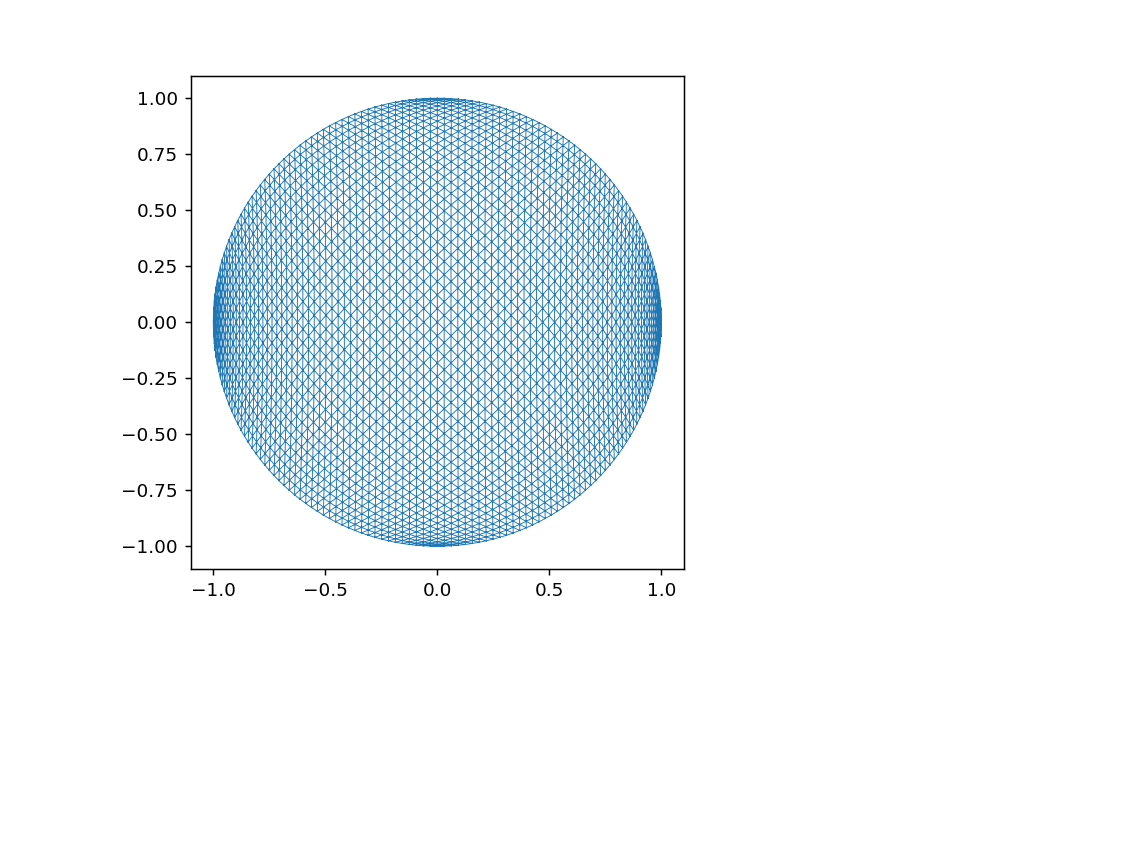

In [8]:
plt.figure()
plt.triplot(x, y, tris, lw=0.5)
plt.axis("image");

In [9]:
x_m, y_m = 0.5*(pts[lines[:, 0], :2] + pts[lines[:, 1],:2]).T
theta = np.arctan2(y_m, x_m)
u_boundary = np.cos(6*theta)
q_boundary = -6*np.cos(6*theta)

In [10]:
ev_pts = pts[:, :2]
ev_x, ev_y = ev_pts.T
solution = eval_sol(ev_pts, pts, lines, u_boundary, q_boundary)

Visualization

<IPython.core.display.Javascript object>


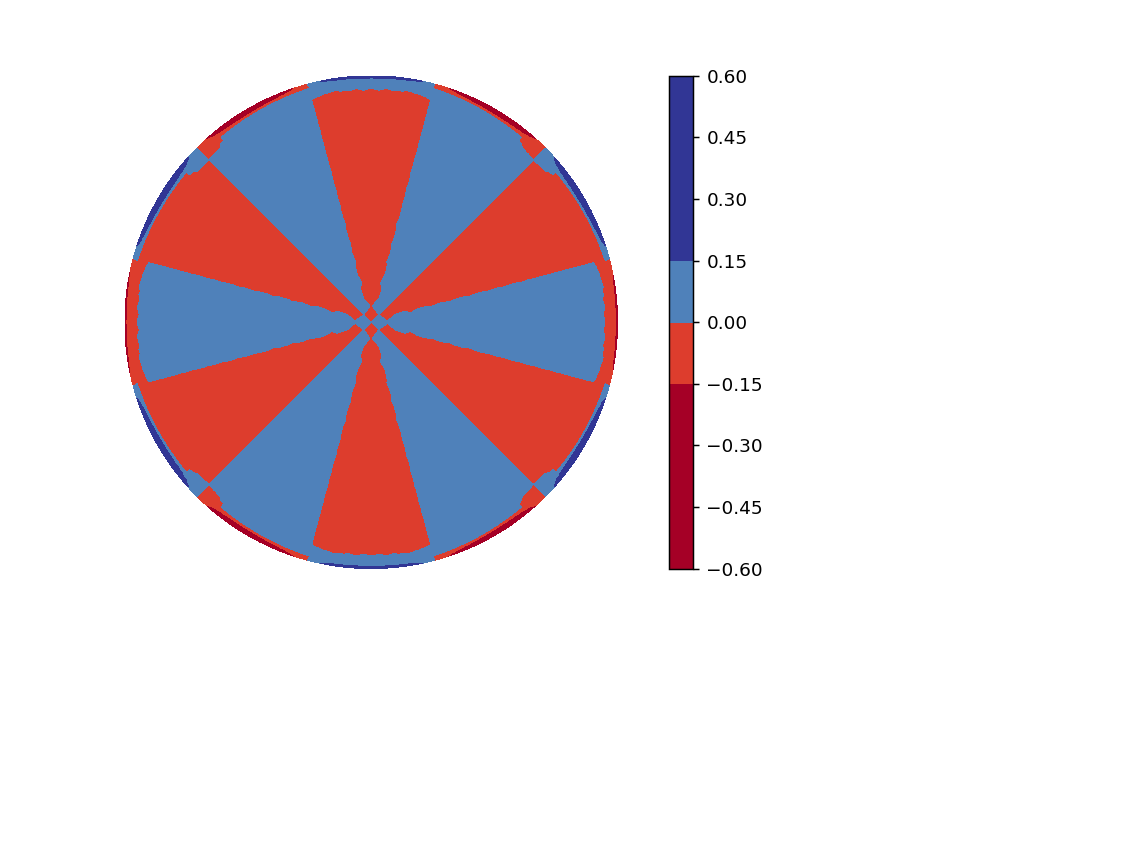

(-1.0, 1.0, -1.0, 1.0)

In [11]:
fig = plt.figure()
plt.tricontourf(ev_x, ev_y, solution, cmap="RdYlBu",
                vmin=-0.1, vmax=0.1)
plt.colorbar()
plt.axis("image")
plt.axis("off")

<IPython.core.display.Javascript object>


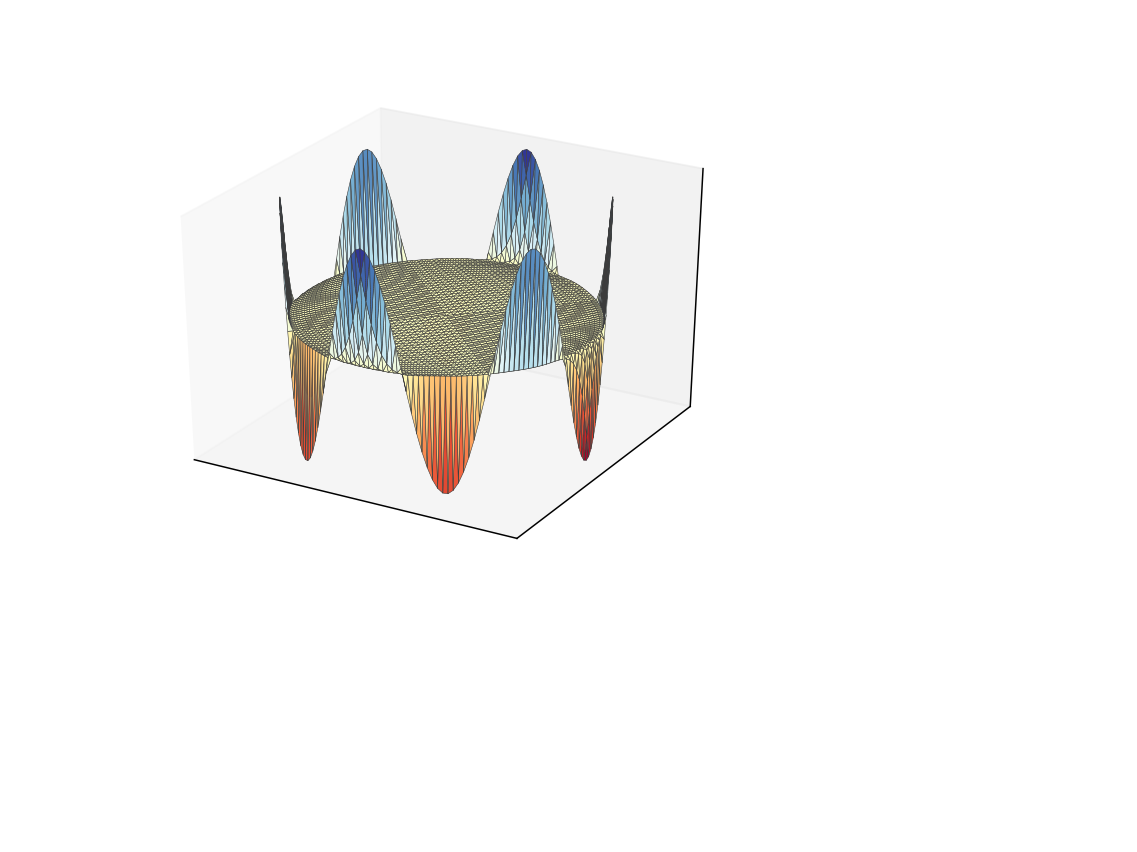

[]

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(ev_x, ev_y, solution, cmap="RdYlBu", lw=0.3,
                edgecolor="#3c3c3c")
plt.xticks([])
plt.yticks([])
ax.set_zticks([])

In [13]:
# Execute this cell to load the notebook's style sheet, then ignore it
from IPython.core.display import HTML
css_file = 'custom.css'
HTML(open(css_file, "r").read())

Then, we can form a system of equations

$$[G]\{q\} = [F]\{u\}\, ,$$

that we obtain by discretization of the boundary. If we take constant
variables over the discretization, the integral can be computed analytically
by

$$G_{nm} = -\frac{1}{2\pi}\left[r \sin\theta\left(\ln|r| - 1\right)
             + \theta r\cos\theta\right]^{\theta_B, r_B}_{\theta_A, r_A}$$

and

$$F_{nm} = \left[\frac{\theta}{2\pi}\right]^{\theta_B}_{\theta_A}$$

for points $n$ and $m$ in different elements, and the subindices
$A, B$ refer to the endpoints of the evaluation element. We should be
careful evaluating this expression since both $r_A$ and $r_B$ can
be (close to) zero and make it *explode*. Also, here it was the main problem
since I forgot to compute the angles with respect to elements that are,
in general, not aligned with horizontal or vertical axes.


For diagonal terms the integrals evaluate to

$$G_{nn} = -\frac{L}{2\pi}\left(\ln\left\vert\frac{L}{2}\right\vert - 1\right)$$

and

$$F_{nn} = - \frac{1}{2}$$

with $L$ the size of the element.

Following is the code. Keep in mind that this code works for purely Dirichlet
problems. For mixed Dirichlet-Neumann the influence matrices would need
rearranging to separate known and unknowns in opposite sides of the equation.